In [1]:
# pip install fbprophet

In [2]:
import pandas as pd # data processing
import numpy as np # linear algebra

import matplotlib.pyplot as plt # data visualization
import seaborn as sns 
sns.set_style('whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize']=(12,6)

from fbprophet import Prophet # forecast model
from sklearn.metrics import mean_absolute_error as MAE # evaluation metrics
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import the data txt file, and merging the date and time columns as one for easier analysis
house_power_data = pd.read_csv('drive/My Drive/household_power_consumption.txt', sep=';', low_memory=False, 
                   na_values=['nan','?'], parse_dates = {'Datetime':['Date','Time']}, infer_datetime_format=True)

In [4]:
house_power_data.shape

(2075259, 8)

In [5]:
house_power_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [6]:
house_power_data.sample(3)

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1855312,2010-06-27 03:16:00,0.224,0.102,238.61,1.0,0.0,1.0,1.0
1691127,2010-03-05 02:51:00,1.518,0.000,242.32,6.2,0.0,0.0,19.0
2056425,2010-11-13 19:09:00,2.298,0.172,235.33,9.8,0.0,1.0,17.0


**Data Preprocessing**

In [7]:
# Using forward fill method to handle all null values
house_power_data = house_power_data.fillna(method='ffill')

In [8]:
house_power_data.isnull().sum()

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [9]:
# creating three new columns out of the datatime
house_power_data['year'] = pd.DatetimeIndex(house_power_data['Datetime']).year
house_power_data['month'] = pd.DatetimeIndex(house_power_data['Datetime']).month
house_power_data['day'] = pd.DatetimeIndex(house_power_data['Datetime']).day

In [10]:
# data types of all columns
house_power_data.dtypes

Datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
year                              int64
month                             int64
day                               int64
dtype: object

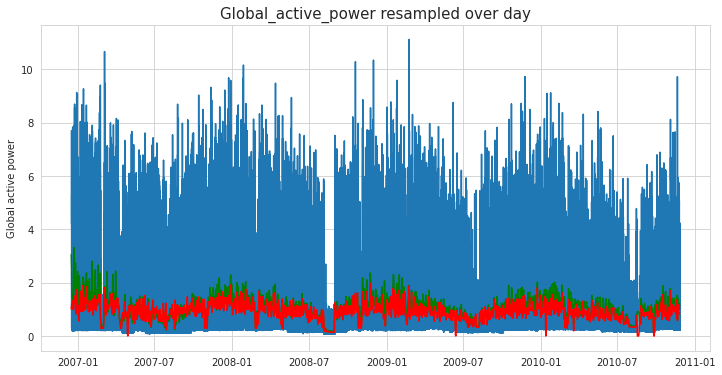

In [11]:
# plotting to observe patterns in the Global_active_power over time, alongside it's daily mean and standard dev.
plt.plot(house_power_data['Datetime'], house_power_data['Global_active_power'])
plt.plot(house_power_data.set_index('Datetime').Global_active_power.resample('D').mean(), color='green')
plt.plot(house_power_data.set_index('Datetime').Global_active_power.resample('D').std(), color='red')
plt.ylabel('Global active power')
plt.title('Global_active_power resampled over day', size=15);

- Fig 1

The plot gives the hypothesis that the data could be time dependent as the mean and standard deviations are unsationary. It is also observed that the yearly household power consumption is usually high around January, and approaches minimum towards July.

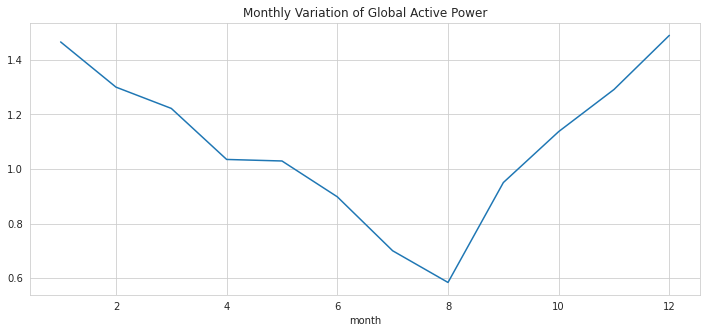

In [17]:
month_group = house_power_data.groupby('month').mean()
fig, ax = plt.subplots(figsize=(12,5))
month_group['Global_active_power'].plot(x=house_power_data.month)
plt.title('Monthly Variation of Global Active Power')
plt.show()

- From this zoomed in plot, we can observe clearly that August is the actual month of minium Global active power, and not July as previously assumed.

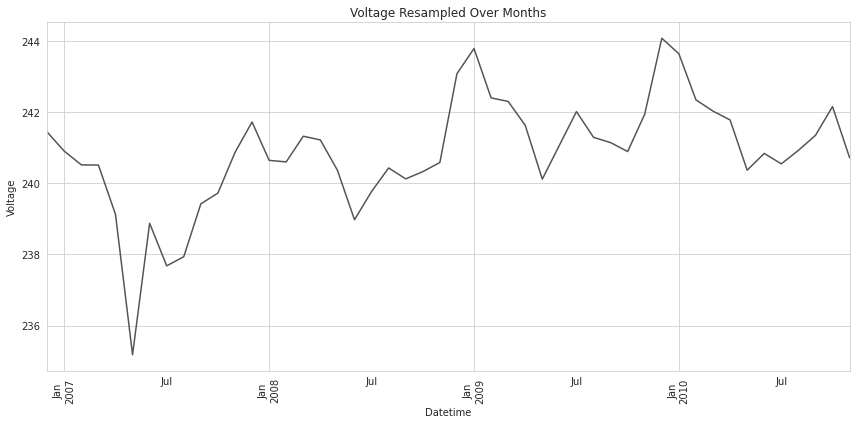

In [12]:
# plotting for Voltage monthly
plt.figure(figsize=(12, 6))
house_power_data.set_index('Datetime').Voltage.resample('M').mean().plot(kind='line',color='0.33')
plt.xticks(rotation=90)
plt.title('Voltage Resampled Over Months')
plt.ylabel('Voltage')
plt.tight_layout()
plt.show()

- Fig. 2

The amount of voltage used, is relatively the same all through. However, just like in the previous plot, there is also a similar trend of rise and fall between January and July.

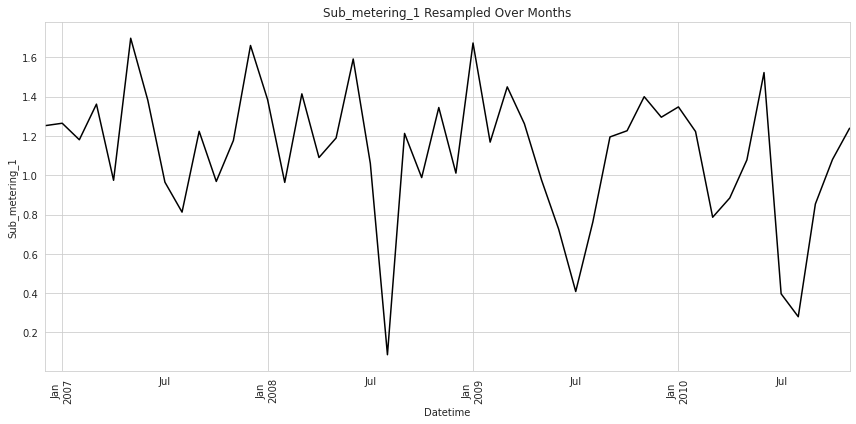

In [13]:
# Trends for Sub_metering_1
house_power_data.set_index('Datetime').Sub_metering_1.resample('M').mean().plot(kind='line',color='k')
plt.xticks(rotation=90)
plt.title('Sub_metering_1 Resampled Over Months')
plt.ylabel('Sub_metering_1')
plt.tight_layout()
plt.show()

- Fig. 3

The trends here too are quite similar to the previous plots

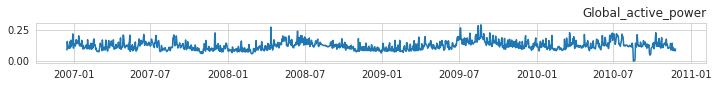

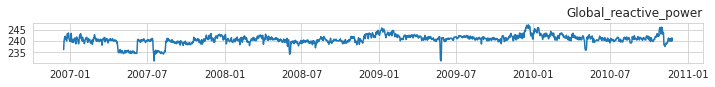

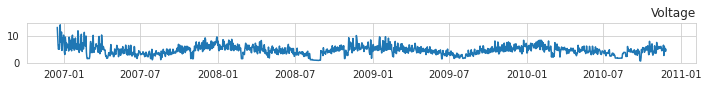

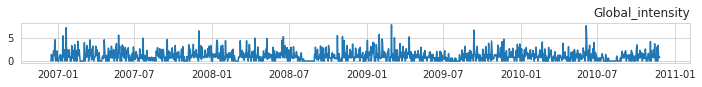

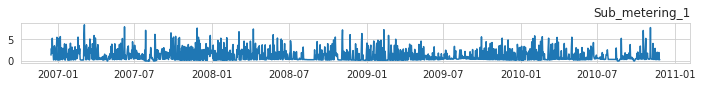

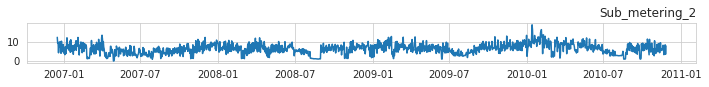

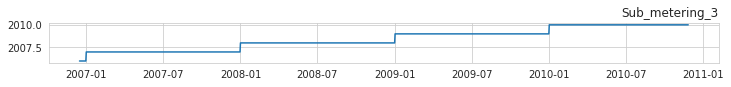

In [15]:
# Resampling the features by days
plot_cols=[1, 2, 3, 4, 5, 6,7]
i=1

#plt.figure(figsize=(15, 10))
groups= plot_cols
plot_df = house_power_data.set_index('Datetime').resample('D').mean()
values = plot_df.values
# map each column to plot
for group in groups:
    plt.subplot(len(plot_cols),1 , i+1)
    plt.plot(plot_df.index, values[:, group])
    plt.title(house_power_data.columns[group], y= 1.0, loc='right')
    plt.show()

- Fig. 4

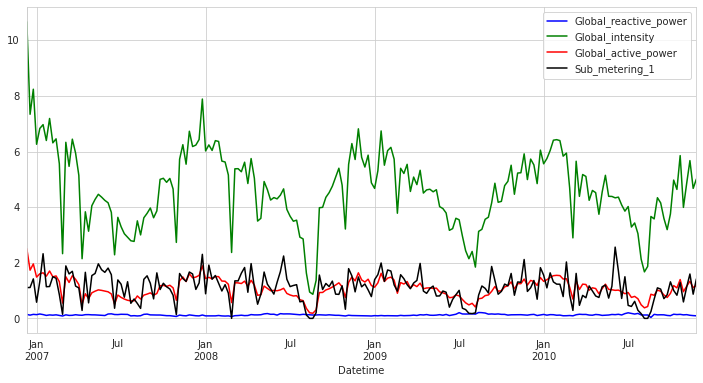

In [16]:
# We resample the features over the week and compare their mean
house_power_data.set_index('Datetime').Global_reactive_power.resample('W').mean().plot(color='b',legend=True)
house_power_data.set_index('Datetime').Global_intensity.resample('W').mean().plot(color='g',legend=True)
house_power_data.set_index('Datetime').Global_active_power.resample('W').mean().plot(color='r',legend=True)
house_power_data.set_index('Datetime').Sub_metering_1.resample('W').mean().plot(color='k',legend=True)
plt.show()

- Fig. 5

### **Univariant Time-Series Forecast**

In [18]:
# Creating the data frame for the forcast: Global active power over datetime
df = house_power_data.loc[:,['Datetime', 'Global_active_power']]
df.dtypes

Datetime               datetime64[ns]
Global_active_power           float64
dtype: object

In [19]:
# Renaming the columns, to suite the built-in expectation for the fbprophet model
headers = ['ds', 'y']
df.columns = headers
df.sample(2)

,ds,y
1433971,2009-09-07 12:55:00,0.210
512381,2007-12-07 13:05:00,2.312


In [20]:
# Downsampling the data to daily to forecast
downsample = df.set_index('ds').resample('D').mean()

# Resetting the index
downsample = downsample.reset_index()
downsample.shape

(1442, 2)

In [21]:
print(downsample.isna().sum())
downsample.head()

ds    0
y     0
dtype: int64


,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


**Model Building**

In [22]:
# Defining the model with a confidence interval of 0.95, and defining other parameters too
model = Prophet(interval_width = 0.95, weekly_seasonality=True,
               seasonality_mode='multiplicative',daily_seasonality=False)

In [24]:
downsample[downsample.ds=='2009-11-26']

,ds,y
1076,2009-11-26,1.110851


In [26]:
len(downsample.loc[1077:,:])

365

In [28]:
# Splitting the data by using the last 365 days in the data as the test set
train = downsample[(downsample['ds'] >= '2006-12-16') & (downsample['ds'] <= '2009-11-26')]
test = downsample[(downsample['ds'] > '2009-11-26')]

In [29]:
# fit model on the train data
model.fit(train)

In [30]:
# Defining the feature (dates) that will be used to make the forecast
future_dates = model.make_future_dataframe(periods =365, freq='D')
future_dates.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [31]:
# Using the feature (future_dates) to predict the Global_active_power for the next 365 days (test['y'])
forecast = model.predict(future_dates)
forecast[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
1437,2010-11-22,1.344396,0.792010,1.949164,1.059162,0.974856,1.142519
1438,2010-11-23,1.441729,0.840698,2.024666,1.059142,0.974537,1.142776
1439,2010-11-24,1.452240,0.839194,2.084488,1.059121,0.974233,1.143034
1440,2010-11-25,1.338724,0.756779,1.914249,1.059101,0.973985,1.143291
1441,2010-11-26,1.429334,0.854282,2.015303,1.059081,0.973618,1.143548


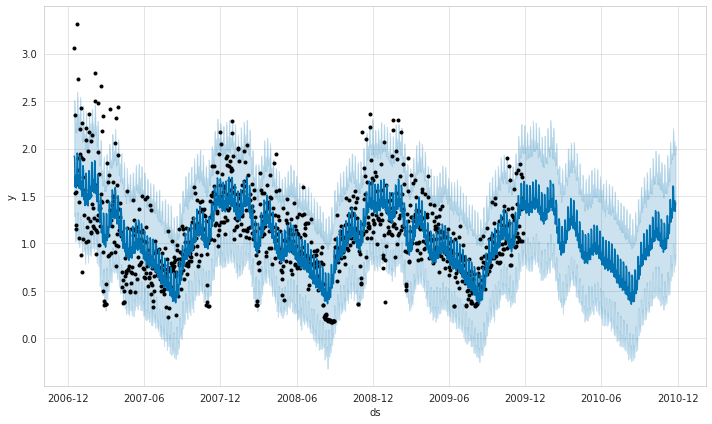

In [ ]:
# Visualizing the model's learning on the train (2006-12-16 - 2009-11-26) 
# and forecast on the test sets (2009-11-27 - end)
fig = model.plot(forecast)

- Fig. 6

Even with the given 95% confidence interval (shaded as sky blue), the model did not do well in fitting some of the outliers. There are still some values outside the predictions.

In the later part of this notebook, more variables will be added to the 'Datetime' to make the predictions, then we can compare the model's performance in both scenerios.

In [61]:
# Merging the forcast of both train and test (yhat) with the train set (train['y'])
metric_df = forecast.set_index('ds')[['yhat']].join(train.set_index('ds')[['y']]).reset_index()
metric_df

,ds,yhat,y
0,2006-12-16,3.096503,3.053475
1,2006-12-17,2.355371,2.354486
2,2006-12-18,1.520506,1.530435
3,2006-12-19,1.160483,1.157079
4,2006-12-20,1.537811,1.545658
...,...,...,...
1437,2010-11-22,1.463008,NaN
1438,2010-11-23,1.135329,NaN
1439,2010-11-24,1.280687,NaN
1440,2010-11-25,1.015950,NaN


In [33]:
# The null values in the 'y' column, represents the test data (test['y']), which wasn't merged in the cell above
# Hence, they will be filled now with the test['y'] values
metric_df['y'] = metric_df['y'].fillna(test['y'])
metric_df.isna().sum()

ds      0
yhat    0
y       0
dtype: int64

In [34]:
# Mean absolute percentage error
def MAPE(predict,target):
    return (abs((target - predict) / target).mean()) * 100

In [35]:
# MAPE score for the test predictions. Recall it is from 1077 and below
MAPE(metric_df.loc[1077:,'y'], metric_df.loc[1077:,'yhat'])

20.760078997273943

In [36]:
# RMSE value for the test prediction
sqrt(MSE(metric_df.loc[1077:,'y'], metric_df.loc[1077:,'yhat']))

0.2780642949523953

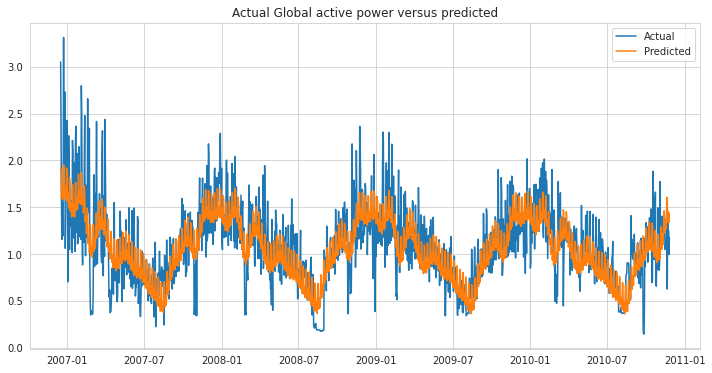

In [38]:
# plot expected vs actual
plt.plot(metric_df.ds, metric_df.y, label='Actual')
plt.plot(metric_df.ds, metric_df.yhat, label='Predicted')
plt.legend()
plt.title('Actual Global active power versus predicted')
plt.show()

- Fig 7

This affirms the conclusion made in Fig 6, that the model did not learn very well, as there are lot of values that didn't fit into the predictions.

**Summary Forecast**

In [39]:
forecastnew = forecast['ds']
forecastnew1 = forecast['yhat']

forecastnew = pd.concat([forecastnew,forecastnew1],axis = 1)
mask = (forecastnew['ds'] > '2009-11-26') & (forecast['ds'] <= '2012-03-01')

forecastedvalues = forecastnew.loc[mask]

mask = (forecastnew['ds'] > '2006-12-16') & (forecastnew['ds'] <= '2009-11-26')
forecastnew = forecastnew.loc[mask]

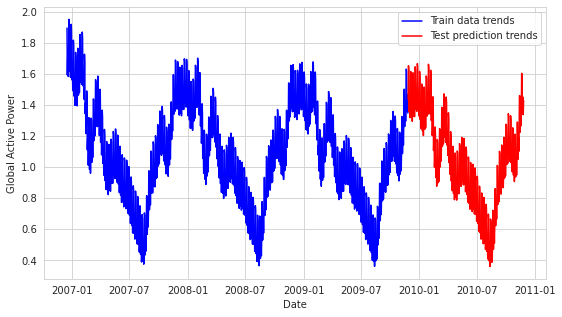

In [43]:
fig, ax1 = plt.subplots(figsize=(9,5))

ax1.plot(forecastnew.set_index('ds'),color='b', label='Train data trends')
ax1.plot(forecastedvalues.set_index('ds'), color = 'r', label='Test prediction trends')
ax1.set_ylabel('Global Active Power')
ax1.set_xlabel('Date')
ax1.legend()

plt.show()

### **Multivariant Forecast**

In [44]:
fb_model = Prophet(interval_width = 0.95, weekly_seasonality=True,
               seasonality_mode='multiplicative',daily_seasonality=True)

In [45]:
house_power_data.head(2)

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,month,day
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006,12,16
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006,12,16


In [46]:
# defining the multivariant features
multi_df = house_power_data.drop(columns=['year','month','day'])

# Checking dtypes to ensure 'Datetime' is in datetime format
multi_df.dtypes

Datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object

In [47]:
# Renaming the columns
multi_df.columns = ['ds','y','add1','add2','add3','add4','add5','add6']

In [48]:
downsample_df = multi_df.set_index('ds').resample('D').mean()

In [49]:
downsample_df.head()

,y,add1,add2,add3,add4,add5,add6
ds,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308063,6.467361,0.000000,1.838889,9.765972


In [50]:
# Resetting index
downsample_df = downsample_df.reset_index()

In [79]:
# Correlation among variables
downsample_df.corr()

,y,add1,add2,add3,add4,add5,add6
y,1.000000,0.041988,0.115853,0.999159,0.542202,0.479273,0.734892
add1,0.041988,1.000000,-0.059322,0.063671,0.316851,0.185792,0.049537
add2,0.115853,-0.059322,1.000000,0.089795,-0.064373,-0.071977,0.186429
add3,0.999159,0.063671,0.089795,1.000000,0.553975,0.488192,0.725905
add4,0.542202,0.316851,-0.064373,0.553975,1.000000,0.256330,0.319934
add5,0.479273,0.185792,-0.071977,0.488192,0.256330,1.000000,0.208234
add6,0.734892,0.049537,0.186429,0.725905,0.319934,0.208234,1.000000


In [51]:
# Adding the multiple features to be used for the forecast, using add_regressor
fb_model.add_regressor('add1', mode='multiplicative')
fb_model.add_regressor('add2', mode='multiplicative')
fb_model.add_regressor('add3', mode='multiplicative')
fb_model.add_regressor('add4', mode='multiplicative')
fb_model.add_regressor('add5', mode='multiplicative')
fb_model.add_regressor('add6', mode='multiplicative')

In [52]:
# Splitting the data by using the last year in the data as the test set, just as before
train_df = downsample_df[(downsample_df['ds'] >= '2006-12-16') & (downsample_df['ds'] <= '2009-11-26')]
test_df = downsample_df[(downsample_df['ds'] > '2009-11-26')]

In [53]:
train_df.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
1,2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2,2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
3,2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
4,2006-12-20,1.545658,0.111804,242.308063,6.467361,0.000000,1.838889,9.765972


In [54]:
fb_model.fit(train_df)

In [55]:
future = fb_model.make_future_dataframe(periods=365, freq='D')
future.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [56]:
len(train_df)

1077

In [57]:
# adding the other (multivariant) features in the 'downsamaple_df' to the 'future' to use in the forecast
future['add1'] = downsample_df['add1'] # Global_reactive_power
future['add2'] = downsample_df['add2'] # Voltage
future['add3'] = downsample_df['add3'] # Global_intensity
future['add4'] = downsample_df['add4'] # Sub_metering_1
future['add5'] = downsample_df['add5'] # Sub_metering_2
future['add6'] = downsample_df['add6'] # Sub_metering_3

In [58]:
future.isna().sum()

ds      0
add1    0
add2    0
add3    0
add4    0
add5    0
add6    0
dtype: int64

In [59]:
# Making predictions for the next 365 days
forecast = fb_model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
1437,2010-11-22,1.463008,0.965248,1.918918,0.595414,0.393992,0.782876
1438,2010-11-23,1.135329,0.748523,1.495528,0.595446,0.393177,0.784077
1439,2010-11-24,1.280687,0.842894,1.691200,0.595478,0.392361,0.785277
1440,2010-11-25,1.015950,0.666564,1.336365,0.595511,0.391546,0.786478
1441,2010-11-26,1.207875,0.790950,1.598914,0.595543,0.390731,0.787679


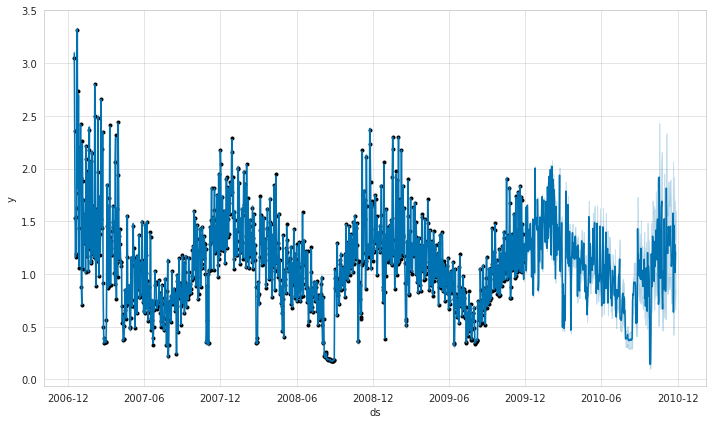

In [60]:
fig = model.plot(forecast)

- Fig. 8

Unlike in Fig. 6, the forecast here is just perfect. The model learnt too well and all values were fitted.

In [62]:
metric_df = forecast.set_index('ds')[['yhat']].join(train_df.set_index('ds')[['y']]).reset_index()
metric_df

,ds,yhat,y
0,2006-12-16,3.096503,3.053475
1,2006-12-17,2.355371,2.354486
2,2006-12-18,1.520506,1.530435
3,2006-12-19,1.160483,1.157079
4,2006-12-20,1.537811,1.545658
...,...,...,...
1437,2010-11-22,1.463008,NaN
1438,2010-11-23,1.135329,NaN
1439,2010-11-24,1.280687,NaN
1440,2010-11-25,1.015950,NaN


In [63]:
metric_df['y'] = metric_df['y'].fillna(test_df['y'])
metric_df.isna().sum()

ds      0
yhat    0
y       0
dtype: int64

In [64]:
MAPE(metric_df.loc[1077:,'y'], metric_df.loc[1077:,'yhat'])

1.4251930059920588

In [65]:
sqrt(MSE(metric_df.loc[1077:,'y'], metric_df.loc[1077:,'yhat']))

0.018636383713074526

From the evaluation metrics, especially the MAPE, we can see the drastic increase in the accuracy compared to the univariant. 

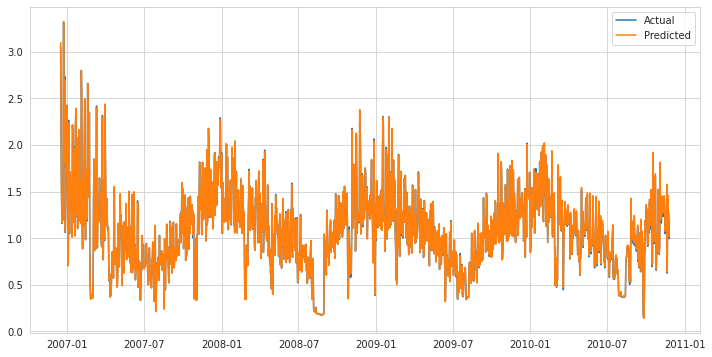

In [66]:
# plot expected vs actual
plt.plot(metric_df.ds, metric_df.y, label='Actual')
plt.plot(metric_df.ds, metric_df.yhat, label='Predicted')
plt.legend()
plt.show()

- Fig. 9

The plot shows also the predictions on the test data along with the actual values, and it is seen that the model was perfect.

To go further, the parameters are meant to be tuned to aviod the overfitting

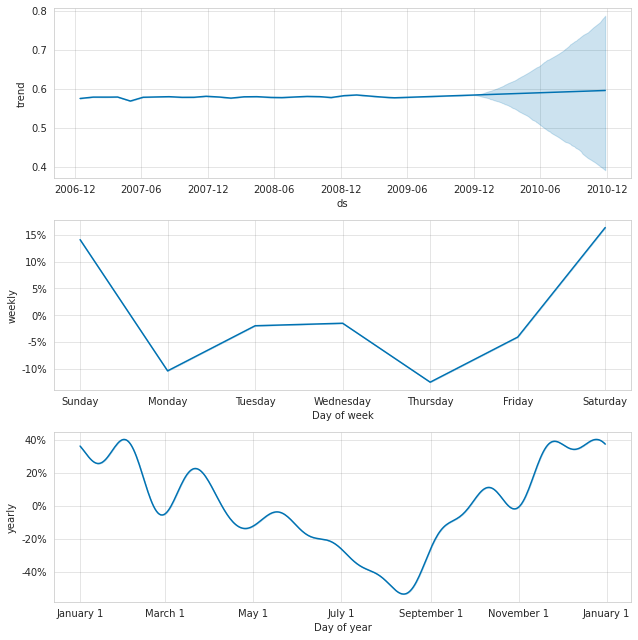

In [67]:
fig = model.plot_components(forecast)

- Fig. 10

Mondays and Thursdays have the lowest values, with the weekends having maximum values. For the months, despite the fluctuations, August had the least values.